In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

spot = datastore.getSpotPrice()

cons_gwh = datastore.getConsumptionGWh()

nuclear_finland_germany_mwh = datastore.getHourlyProduction_nuclear_EU()
germany_all = datastore.getHourlyProduction_Germany_all()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

hydroReservoirs = datastore.getWeeklyHydroReservs()

temp_pen = datastore.getDailyWeather()

# stationCap = datastore.getStationCap_forecast()
# transTo = datastore.getTransmissionCapTo_forecast()
# transFrom = datastore.getTransmissionCapFrom_forecast()

# productionCap = datastore.getProductionCap_forecast()

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionSE1GWh', 'ConsumptionSE2GWh', 'ConsumptionSE3GWh',
       'ConsumptionSE4GWh'],
      dtype='object') : 24
Missing values in Index(['nucFI(MWh)', 'nucDE(MWh)'], dtype='object') : 1224
Missing values in Index(['wind(Mwh)', 'solar(Mwh)', 'trm(Mwh)', 'biomass(Mwh)', 'coal(MWh)',
       'gas(MWh)', 'oil(MWh)', 'lignite(MWh)', 'nuc(MWh)', 'pump(MWh)',
       'other(MWh)', 'waste(MWh)'],
      dtype='object') : 1537
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 94
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 240
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 259
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 251
Missing v

In [2]:
import calendar_features as cf

dataset = pd.concat([spot, cons_gwh, production_se1_mwh, production_se2_mwh, 
                                    production_se3_mwh, production_se4_mwh, temp_pen, hydroReservoirs], axis=1)
dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, daylight_features, holiday_features], axis=1)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54408 entries, 2018-01-01 00:00:00 to 2024-03-16 23:00:00
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   spotPrice                   54408 non-null  float64
 1   ConsumptionSE1GWh           54408 non-null  float64
 2   ConsumptionSE2GWh           54408 non-null  float64
 3   ConsumptionSE3GWh           54408 non-null  float64
 4   ConsumptionSE4GWh           54408 non-null  float64
 5   waterSE1(MWh)               54408 non-null  float64
 6   windSE1(MWh)                54408 non-null  float64
 7   trmSE1MWh                   54408 non-null  float64
 8   waterSE2(MWh)               54408 non-null  float64
 9   windSE2(MWh)                54408 non-null  float64
 10  solSE2MWh                   54408 non-null  float64
 11  trmSE2MWh                   54408 non-null  float64
 12  OthSE2MWh                   54408 non-null  float64
 

In [3]:
from sklearn.preprocessing import MinMaxScaler

past_cov = dataset.iloc[:, 1:28]
future_cov = dataset.iloc[:, 28:]
target = dataset.iloc[:,0].to_frame()

train_split = int(len(dataset) * 0.7)
validation_split = int(len(dataset) * 0.85)
test_split = int(len(dataset))

past_cov_scaler = MinMaxScaler()
future_cov_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

past_cov_scaled = past_cov_scaler.fit_transform(past_cov)
future_cov_scaled = future_cov_scaler.fit_transform(future_cov)
target_scaled = target_scaler.fit_transform(target)

In [ ]:
train_df = pd.concat([pd.DataFrame(past_cov_scaled[:train_split]), 
                      pd.DataFrame(future_cov_scaled[:train_split]), 
                      pd.DataFrame(target_scaled[:train_split])], axis=1)

val_df = pd.concat([pd.DataFrame(past_cov_scaled[train_split:validation_split]),
                    pd.DataFrame(future_cov_scaled[train_split:validation_split]),
                    pd.DataFrame(target_scaled[train_split:validation_split])], axis=1)

test_df = pd.concat([pd.DataFrame(past_cov_scaled[validation_split:test_split]),
                        pd.DataFrame(future_cov_scaled[validation_split:test_split]),
                        pd.DataFrame(target_scaled[validation_split:test_split])], axis=1)

print(f"train_df: {train_df.shape}")
print(f"val_df: {val_df.shape}")
print(f"test_df: {test_df.shape}") 

In [28]:
x_train_1 = pd.DataFrame(past_cov_scaled[:train_split])
x_train_2 = pd.DataFrame(future_cov_scaled[:train_split])
x_train = pd.concat([x_train_1, x_train_2], axis=1)

x_val_1 = pd.DataFrame(past_cov_scaled[train_split:validation_split])
x_val_2 = pd.DataFrame(future_cov_scaled[train_split:validation_split])
x_val = pd.concat([x_val_1, x_val_2], axis=1)

x_test_1 = pd.DataFrame(past_cov_scaled[validation_split:test_split])
x_test_2 = pd.DataFrame(future_cov_scaled[validation_split:test_split])
x_test = pd.concat([x_test_1, x_test_2], axis=1)

y_train = pd.DataFrame(target_scaled[:train_split])
y_val = pd.DataFrame(target_scaled[train_split:validation_split])
y_test = pd.DataFrame(target_scaled[validation_split:test_split])


In [89]:
import keras

past = 24 * 2
step = 1

seq_length = int(past / step)
batch_size = 32

train_gen_1 = keras.utils.timeseries_dataset_from_array(
    x_train, y_train, sequence_length=seq_length, sequence_stride=1, sampling_rate=1, batch_size=batch_size
)
val_gen_1 = keras.utils.timeseries_dataset_from_array(
    x_val, y_val, sequence_length=seq_length, sequence_stride=1, sampling_rate=1, batch_size=batch_size
)
test_gen_1 = keras.utils.timeseries_dataset_from_array(
    x_test, y_test, sequence_length=seq_length, sequence_stride=1, sampling_rate=1, batch_size=batch_size
)


In [ ]:
from keras.layers import LSTM, Dense, Input
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

model = keras.Sequential([
    Input(shape=(seq_length, x_train_1.shape[1])) ,
    LSTM(8, activation= "relu" , return_sequences=True),
    Dense(1),
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
model.summary()


Epoch 1/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0036 - mae: 0.0436
Epoch 2/30
  26/1188 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0034 - mae: 0.0488

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 8.4480e-04 - mae: 0.0208
Epoch 3/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 9.0176e-04 - mae: 0.0190
Epoch 4/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0010 - mae: 0.0187
Epoch 5/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 8.6276e-04 - mae: 0.0166
Epoch 6/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 6.6458e-04 - mae: 0.0146
Epoch 7/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 5.1516e-04 - mae: 0.0133
Epoch 8/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.9206e-04 - mae: 0.0135
Epoch 9/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3.7273e-04 - mae: 0.0120
Epoch 10/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.4408e-04 - mae: 0.0114
Epoch 11/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.1641e-04 - mae: 0.0106
Epoch 12/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3.4274e-04 - mae: 0.0106
Epoch 13/30
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step 

KeyError: 'val_loss'

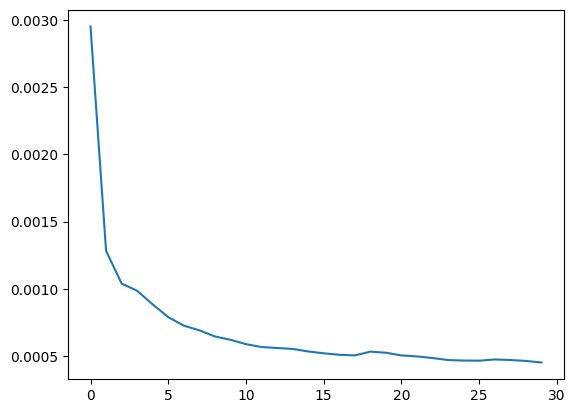

In [97]:

epochs = 30
log = model.fit([x_train_encoder, x_train_decoder], y_train_encoder,
                epochs=epochs, 
                callbacks=[early_stopping], shuffle=False)

plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

In [26]:
x, y = next(test_gen.as_numpy_iterator())

y_pred = model.predict(test_gen)

mae = keras.losses.MeanAbsoluteError()
print(mae(y_test, y_pred).numpy())

y_pred = target_scaler.inverse_transform(y_pred)
actuals = target_scaler.inverse_transform(y_test)

plt.figure(figsize=(17, 6))
plt.plot(y_pred, label='Predictions', linestyle='--')
plt.plot(actuals, label='Actuals', alpha=0.7)
# plt.plot(target.values[(validation_split+25):(test_split)], label='Validation', alpha=0.7)
plt.legend()
plt.show()

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [8162,1] vs. [8115,48] [Op:Sub] name: 

In [40]:
print(target.iloc[validation_split:test_split].head(1))
print(target_scaled[validation_split:test_split][0])
print(Y_test[0])

print(test_df.iloc[0])

                     spotPrice
Date                          
2023-04-04 07:00:00    1971.73
[0.28925384]
[0.34394904]
0     0.353503
1     0.237349
2     0.583266
3     0.646018
4     0.807755
5     0.223207
6     0.485678
7     0.803015
8     0.157525
9     0.085584
10    0.773531
11    0.000170
12    0.669458
13    0.095476
14    0.624388
15    0.053192
16    0.550211
17    0.039220
18    0.945562
19    0.076985
20    0.120641
21    0.353731
22    0.001618
23    0.375676
24    0.000000
25    0.020249
26    0.166578
0     0.833333
1     0.272727
2     0.166667
3     0.000000
4     0.304348
5     0.400000
6     0.600000
7     0.600000
0     0.289254
Name: 0, dtype: float64
